In [18]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras as tfk

from sklearn.preprocessing import StandardScaler
from keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
plt.style.use('seaborn')
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras import backend as K

from utils import preprocess_time_series_v2

In [ ]:
pip uninstall matplotlib
python -m pip install --upgrade pip
pip install matplotlib

In [19]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)
    def get_config(self):
        return {"W":self.W, "P":self.P, "w":self.w, "p":self.p}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [20]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')

X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series_v2(df, date_init='2016', date_final='2017', date_val='2018', date_test='2019', 
                            past_timestamps=96, forecasting_horizon=6, 
                            standarize=True, metafeatures=False, tendency=False)

                      Date  value
0      2016-01-02 23:00:00  24151
1      2016-01-03 00:00:00  22170
2      2016-01-03 01:00:00  20691
3      2016-01-03 02:00:00  19737
4      2016-01-03 03:00:00  19437
...                    ...    ...
34940  2019-12-28 19:00:00  29282
34941  2019-12-28 20:00:00  29266
34942  2019-12-28 21:00:00  28022
34943  2019-12-28 22:00:00  25964
34944  2019-12-28 23:00:00  24680

[34945 rows x 2 columns]
(17497, 1)
(8760, 1)
(8688, 1)
shape train/val (17497, 1) (8760, 1) (8688, 1)
Tamano de la serie temporal 2
Tamano de la serie temporal 2
Tamano de la serie temporal 2
shape train/val (17396, 96, 1, 1) (8659, 96, 1, 1) (8587, 96, 1, 1)
(17396, 96, 1, 1)
/home/blasting/TFG_TimeSeries/notebooks/utils.py:131: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  val_data = df[date_val].to_numpy()
/home/bl

In [21]:
X_val.shape

(8659, 96, 1)

In [22]:
y_val.shape

(8659, 6)

In [23]:

n_neurons_per_layer = int(2/3*(X_train.shape[1]*X_train.shape[2]))

inputs = tfk.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
time2vec = T2V(128)(inputs)
rnn_output = tfk.layers.SimpleRNN(n_neurons_per_layer, return_sequences=True)(time2vec)
rnn_output = tfk.layers.SimpleRNN(n_neurons_per_layer)(rnn_output)

outputs = tfk.layers.Dense(y_train.shape[1], activation='linear')(rnn_output)

model = tfk.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tfk.losses.MeanSquaredError(), optimizer= tfk.optimizers.Adam(),
metrics=[tfk.metrics.MeanAbsoluteError()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 1)]           0         
_________________________________________________________________
t2v_2 (T2V)                  (None, 96, 129)           12608     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 96, 64)            12416     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 33,670
Trainable params: 33,670
Non-trainable params: 0
_________________________________________________________________


In [24]:
batch_size = 256
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=2, 
                    validation_data=(X_val, y_val)) 


loss = history.history['loss']            #entrenamiento
val_loss = history.history['val_loss']    #validacion
#val_mse = history.history['val_mse']    #validacion
#mse = history.history['mse']    #validacion


Epoch 1/2
68/68 [==============================] - 15s 187ms/step - loss: 0.5711 - mean_absolute_error: 0.5846 - val_loss: 0.1180 - val_mean_absolute_error: 0.2447
Epoch 2/2
68/68 [==============================] - 11s 156ms/step - loss: 0.1072 - mean_absolute_error: 0.2362 - val_loss: 0.0935 - val_mean_absolute_error: 0.2154


In [25]:
model.save('RNNTIME2VEC.h5')

TypeError: ('Not JSON Serializable:', <tf.Variable 't2v_2/W:0' shape=(1, 128) dtype=float32, numpy=
array([[ 0.02118238, -0.01409312, -0.03196336,  0.00245461, -0.01292165,
         0.02008806, -0.04531889,  0.00137565, -0.01116915,  0.0107634 ,
         0.03128046, -0.00321892, -0.0086026 ,  0.04775342,  0.03104472,
         0.02213481, -0.01163601, -0.02994091, -0.0360892 , -0.03775782,
         0.05304747,  0.00488191,  0.02344197,  0.00166823,  0.03100973,
         0.03618911,  0.02594844,  0.03746195,  0.03960712,  0.01977736,
        -0.016643  , -0.01883309, -0.06312703,  0.04344108, -0.04171871,
        -0.05009668, -0.04023457,  0.02881697,  0.03498054,  0.02005816,
        -0.0505829 , -0.02223783, -0.00428302,  0.00132922,  0.05049652,
        -0.05186313, -0.04780839,  0.0477134 , -0.02743445, -0.01639722,
         0.00493753, -0.02336911, -0.0209298 ,  0.02367516,  0.01421044,
        -0.01400462,  0.02295539,  0.0487198 ,  0.02028317, -0.03675416,
         0.00058974, -0.04899782, -0.00313134, -0.00575011, -0.04227841,
         0.01084147,  0.03877078,  0.05296882, -0.04088791, -0.01076223,
         0.02585274,  0.01652593,  0.0126732 ,  0.02955665,  0.02689901,
         0.01967373, -0.04531298,  0.00059426, -0.02285433,  0.03674375,
         0.04050251,  0.01577668,  0.03788115,  0.00374357, -0.06964532,
         0.04503693,  0.04832961, -0.01774937, -0.00878083,  0.04516765,
        -0.02265462, -0.04817704,  0.02914366, -0.04706992, -0.06017355,
        -0.04036237, -0.03742   ,  0.03429891,  0.05421214, -0.03335588,
         0.01280241,  0.0135654 , -0.02412652,  0.02788357, -0.01152074,
        -0.02284758, -0.03734928,  0.02607092, -0.00872124,  0.02409124,
        -0.02926717, -0.02018167,  0.03315676, -0.02524465, -0.03282256,
         0.0271717 , -0.03428991, -0.0296408 , -0.00417048, -0.03583212,
         0.00880312, -0.04045613,  0.00173657, -0.05063621,  0.03755695,
         0.0376938 ,  0.03943142,  0.0153126 ]], dtype=float32)>)

In [12]:
def inverse_transform(yhat, y, scaler):
	return scaler.inverse_transform(y),  scaler.inverse_transform(yhat)


In [13]:
y_hat = model.predict(X_test)
y_hat_2 = model.predict(X_val)

y_test, y_hat = inverse_transform(y_hat, y_test, scaler)
y_val, y_hat_2 = inverse_transform(y_hat_2, y_val, scaler)

In [14]:
y_hat

array([[26534.096, 24805.86 , 24183.053, 23916.19 , 23853.992, 24475.346],
       [24669.498, 23459.527, 23725.953, 23590.217, 24833.172, 27164.889],
       [23869.68 , 23670.158, 23893.082, 25034.809, 27795.191, 30906.822],
       ...,
       [26224.6  , 27073.053, 29428.312, 30478.154, 29638.164, 28050.002],
       [27105.05 , 28405.68 , 29829.658, 29238.408, 27915.371, 25587.904],
       [29278.928, 29859.562, 29823.812, 28161.252, 26046.137, 23774.467]],
      dtype=float32)

In [15]:
y_val

array([[24999., 23645., 23050., 22811., 23057., 24601.],
       [23645., 23050., 22811., 23057., 24601., 27715.],
       [23050., 22811., 23057., 24601., 27715., 29787.],
       ...,
       [26628., 29371., 30659., 29852., 28274., 25926.],
       [29371., 30659., 29852., 28274., 25926., 24589.],
       [30659., 29852., 28274., 25926., 24589., 23459.]])

In [16]:
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts(test, forecasts, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = mean_absolute_error(actual, predicted)
		print('t+%d MSE: %f' % ((i+1), rmse))

In [17]:
print("test")
evaluate_forecasts(y_test, y_hat, 6)

print("validacion")
evaluate_forecasts(y_val, y_hat_2, 6)

test
t+1 MSE: 287.258520
t+2 MSE: 313.336407
t+3 MSE: 398.929960
t+4 MSE: 443.421967
t+5 MSE: 483.057347
t+6 MSE: 532.431611
validacion
t+1 MSE: 289.287922
t+2 MSE: 318.554732
t+3 MSE: 394.627591
t+4 MSE: 440.581376
t+5 MSE: 494.604436
t+6 MSE: 535.761959


In [1]:
(287.258520 + 313.336407 + 398.929960 + 443.421967 + 483.057347 + 532.431611) /6

409.73930199999995

In [17]:
y_val.shape

(10383, 6)

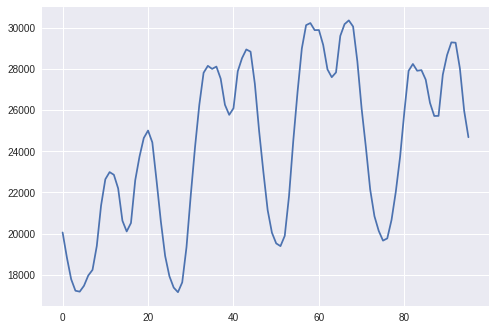

In [18]:
data_array = df['value'].to_numpy()
train_split = int(.7 * int(data_array.shape[0]))
val_data_plot = data_array[train_split:]
plt.plot(val_data_plot[-96:])


In [19]:
y_val

array([[23573., 27320., 29847., 30525., 31152., 31389.],
       [27320., 29847., 30525., 31152., 31389., 31555.],
       [29847., 30525., 31152., 31389., 31555., 31677.],
       ...,
       [25716., 27715., 28666., 29282., 29266., 28022.],
       [27715., 28666., 29282., 29266., 28022., 25964.],
       [28666., 29282., 29266., 28022., 25964., 24680.]])

In [20]:
y_hat

array([[23212.117, 25945.465, 28041.676, 29132.498, 29989.922, 30328.25 ],
       [26277.502, 28086.117, 29349.984, 30073.361, 30561.217, 30809.89 ],
       [29400.484, 30376.55 , 30981.691, 31198.648, 31574.787, 31616.453],
       ...,
       [26577.219, 27778.03 , 28873.818, 29795.846, 29808.043, 28022.041],
       [27178.264, 28362.105, 28843.81 , 28717.373, 27467.533, 25182.684],
       [28631.164, 29162.686, 28808.943, 27273.023, 25362.12 , 23707.62 ]],
      dtype=float32)

In [21]:
#val_data_plot.shape[0]-y_val.shape[0]
val_data_plot = val_data_plot[96:]

In [22]:
val_data_plot

array([23573, 27320, 29847, ..., 28022, 25964, 24680])

(144,)
(144, 6)


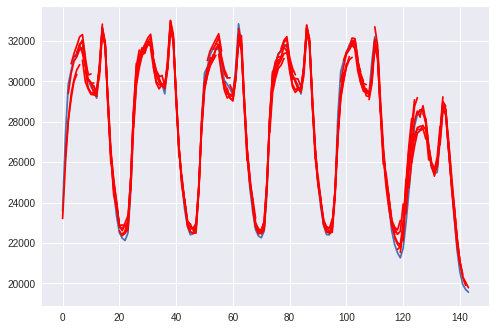

In [27]:
# plot the entire dataset in blue

test_size = 144
real_data = val_data_plot[:test_size]
print(real_data.shape)
forecastings = y_hat[:test_size]
print(forecastings.shape)
plt.plot(real_data)
# plot the forecasts in red
for i in range(len(forecastings)):
    xaxis = np.arange(i, forecastings.shape[1]+i)
    if xaxis[-1] > real_data.shape[0]-1:
        continue
    plt.plot(xaxis, forecastings[i], color='red')
# show the plot
plt.show()

In [24]:
real_data

array([23573, 27320, 29847, 30525, 31152, 31389, 31555, 31677, 30842,
       30088, 29718, 29530, 29158, 30599, 32656, 31816, 29002, 26348,
       24640, 23335, 22510, 22242, 22121, 22488, 24522, 28178, 30532,
       30951, 31368, 31675, 31922, 31899, 30989, 30375, 30052, 29870,
       29373, 30794, 32774, 31876, 29102, 26608, 25006, 23652, 22822,
       22407, 22457, 22637, 24536, 28148, 30396, 30693, 31304, 31611,
       31554, 31598, 30697, 30035, 29854, 29619, 29312, 30648, 32832,
       31856, 28867, 26404, 24684, 23533, 22658, 22349, 22257, 22585,
       24436, 28086, 30428, 30853, 31376, 31455, 31794, 31791, 30931,
       30306, 30021, 29796, 29367, 30822, 32584, 31742, 28825, 26559,
       24945, 23727, 22854, 22418, 22402, 22755, 24550, 28300, 30464,
       30980, 31402, 31782, 32010, 31984, 31031, 30190, 29746, 29520,
       29446, 30979, 32196, 31306, 28753, 26555, 25187, 23772, 22581,
       21928, 21515, 21266, 21741, 22992, 24503, 26113, 27774, 28339,
       28527, 28610,

In [25]:
forecastings

array([[23212.117, 25945.465, 28041.676, 29132.498, 29989.922, 30328.25 ],
       [26277.502, 28086.117, 29349.984, 30073.361, 30561.217, 30809.89 ],
       [29400.484, 30376.55 , 30981.691, 31198.648, 31574.787, 31616.453],
       ...,
       [27741.371, 27844.195, 27507.217, 26406.424, 25654.86 , 25659.986],
       [27286.21 , 26843.74 , 26262.05 , 25154.06 , 25195.504, 26641.361],
       [26985.578, 25947.916, 25098.5  , 25421.86 , 26543.797, 28172.568]],
      dtype=float32)